# Massachusetts road segmentation

## Requirements

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#import torchinfo
from torch.utils.tensorboard import SummaryWriter
from  torch.utils.data import DataLoader,Dataset
from torchmetrics.classification import BinaryJaccardIndex
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import albumentations as album


## Hyperparameters and constants

In [3]:
lr = 0.0001
batch_size = 32
epochs = 55

class_number = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## NN model

In [4]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=2,
    activation=nn.ReLU)


model = model.to(device)

## Optimizer and Loss function

In [5]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True, threshold=1e-3)

## Data spliting

In [7]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map


def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def prepare_to_network():
    return album.Lambda(image=to_tensor, mask=to_tensor)

def transform_train():
    train_transform = album.Compose(
        [
            album.OneOf([
                    album.HorizontalFlip(p=1),
                    album.VerticalFlip(p=1),
                    album.RandomRotate90(p=1),
                ],
                p=0.75,
            ),
            album.Normalize(mean=[0.5,0.5,0.5],
                            std=[0.5,0.5,0.5], always_apply=True)
        ]
    )
    return train_transform


def transform_test():
    test_transform = album.Compose([
        album.Normalize(mean=[0.5,0.5,0.5],
                        std=[0.5,0.5,0.5], always_apply=True)
    ])
    return test_transform



class RoadsDataset(Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

In [8]:
data_dir = "/usr/src/app/roads_dataset_cropped/tiff"

x_train_dir = os.path.join(data_dir, 'train')
y_train_dir = os.path.join(data_dir, 'train_labels')

x_valid_dir = os.path.join(data_dir, 'val')
y_valid_dir = os.path.join(data_dir, 'val_labels')

x_test_dir = os.path.join(data_dir, 'test')
y_test_dir = os.path.join(data_dir, 'test_labels')

class_dict = pd.read_csv("/usr/src/app/roads_dataset_cropped/label_class_dict.csv")
CLASSES = class_dict['name'].tolist()
CLASSES_RGB = class_dict[['r','g','b']].values.tolist()

In [9]:
train_set = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=CLASSES_RGB, augmentation=transform_train(), preprocessing=prepare_to_network())
valid_set = RoadsDataset(x_valid_dir, y_valid_dir, class_rgb_values=CLASSES_RGB, augmentation=transform_test(), preprocessing=prepare_to_network())
test_set = RoadsDataset(x_test_dir, y_test_dir,class_rgb_values=CLASSES_RGB, augmentation=transform_test(), preprocessing=prepare_to_network())

train_loader = DataLoader(train_set,batch_size=batch_size,num_workers=20,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=batch_size,num_workers=20,shuffle=True)
test_loader = DataLoader(test_set,batch_size=batch_size,num_workers=20,shuffle=True)

## Training

In [10]:
def trainStep(epoch):
    running_loss = 0.0
    model.train()

    iou = BinaryJaccardIndex(num_classes=2)
    iou.to(device)

    for step, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)                   
        iou.update(outputs, labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if step % 450 == 449:
            print(f'[{epoch + 1}, {step + 1:5d}] train loss: {loss.item():.3f}')
    
    
    return running_loss, iou.compute()


def validStep():
    model.eval()
    running_loss = 0.0
    iou = BinaryJaccardIndex(num_classes=2)
    iou.to(device)
    
    with torch.no_grad():
        for step, data in enumerate(valid_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)                   
            iou.update(outputs, labels)
               
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    return running_loss,iou.compute() 

In [ ]:
train_losses = []
valid_losses = []

print('Training started')
tb = SummaryWriter()

train_step_number = len(train_loader)
val_step_number = len (valid_loader)

for epoch in range(epochs):
    train_loss, train_metric = trainStep(epoch)
    valid_loss, valid_metric = validStep()     
    
    print(f'train_metric: {train_metric:.3%}\n valid_metric: {valid_metric:.3%}')
    scheduler.step(valid_loss/val_step_number)
    
    tb.add_scalars(f"Losses",{"Train": train_loss/train_step_number,"Valid": valid_loss/val_step_number }, epoch)
    tb.add_scalars(f"Metrics",{"Train": train_metric,"Valid": valid_metric }, epoch)
    
    train_losses.append(train_loss/train_step_number)
    valid_losses.append(valid_loss/val_step_number)
    
    #tb.add_scalar(f"Losses/train",train_loss, epoch)
    #tb.add_scalar(f"Losses/valid",val_loss, epoch)
    if epoch>=5:
      torch.save(obj=model.state_dict(), f=f"./model_epoch{epoch+1}.pth")

print('Training finished')

## Testing

In [40]:
def shower(images,labels,outputs):
    fig, axes = plt.subplots(1, 3)
    fig.set_figwidth(12) 
    fig.set_figheight(6)

    axes[0].set_title('GT')
    axes[0].imshow(images[3].numpy().transpose(2, 1, 0))

    axes[1].set_title('Label')
    axes[1].imshow(reverse_one_hot(labels[3].numpy().transpose(2, 1, 0)))

    axes[2].set_title('Predict')
    axes[2].imshow(reverse_one_hot(outputs[3].numpy().transpose(2, 1, 0)))
            
    plt.show()

Testing started


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


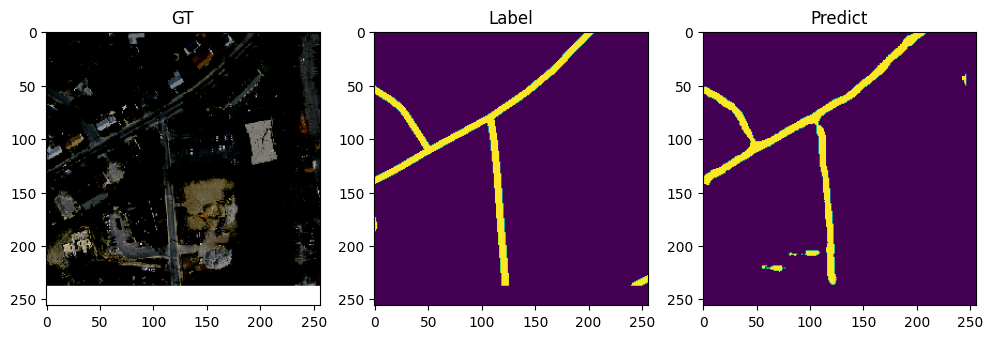

Testing finished
Metrics: 89.519%


In [42]:
print('Testing started')

dataiter = iter(test_loader)
images, labels = next(dataiter)

iou = BinaryJaccardIndex(num_classes=2)
iou.to(device)

flag = False

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)   
                    
        if not flag:
            shower(images.cpu(),labels.cpu(),outputs.cpu())
            flag = True
        
        iou.update(outputs,labels)
         

print('Testing finished')     
print(f"Metrics: {iou.compute():.3%}")